This is to generate the relevant data from the exact diagonalziation that I myself coded

In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import UnivariateSpline

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *

In [56]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [58]:
data_route = "../../data/exact_diag_new/L=40/"

J=1


In [59]:
def get_time_at_bond(Times, N_bond):
    """ we estimate the time the qpc wavepacket spends at the bond with the qubit from the  FWHM of the
    occupations at the bond sites as a function of time """
    
    # estimate FWHF with an interpolation
    spline = UnivariateSpline(Times, N_bond - np.max(N_bond) / 2, s=0)
    bond_root = spline.roots()  # find the roots
    if (len(bond_root) < 2):
        print("not possible to estimate time at bond for ")
        print(Param_dict)
        tau_b = -Times[-1]
    else:
        # the first two roots yield the width at half maximum
        tau_b = bond_root[1] - bond_root[0]
    return tau_b


# Checking correct initial condition

Here we make sure that the occupation of the qubit 0 state is at roughly the same  for all different velocities. We achieve this by tweaking the initial conditions at at $\Omega=0$

In [60]:
# file_list = get_file_names_on(["om0.1","bw2.0","t0.1", "dd0fixed"], data_route)
file_list = get_file_names_on(["om0.0","Del4.0","t0.1"], data_route)

file_list

['exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.9425_bindex20_maxtau70.000_tstep0.140_alpha0.265_beta0.735_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.1571_bindex20_maxtau70.000_tstep0.140_alpha0.793_beta0.207_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.3142_bindex20_maxtau70.000_tstep0.140_alpha0.795_beta0.205_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.4923_bindex20_maxtau70.000_tstep0.140_alpha0.373_beta0.627_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.7854_bindex20_maxtau70.000_tstep0.140_alpha0.215_beta0.785_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.2566_bindex20_maxtau70.000_tstep0.140_alpha0.348_beta0.652_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k0.4712_bindex20_maxtau70.000_tstep0.140_alpha0.409_beta0.591_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.0996_bindex20_maxtau70.000_tstep0.140_alpha0.313_beta0.687_phi0.0.h5',
 'exact_L40_J1.0_t0.1_om0.0_Del4.0_xo5_k1.4137_bindex20_maxtau70.000_tstep0.140_alpha0.368_beta0

Text(0.5, 0, 'Time')

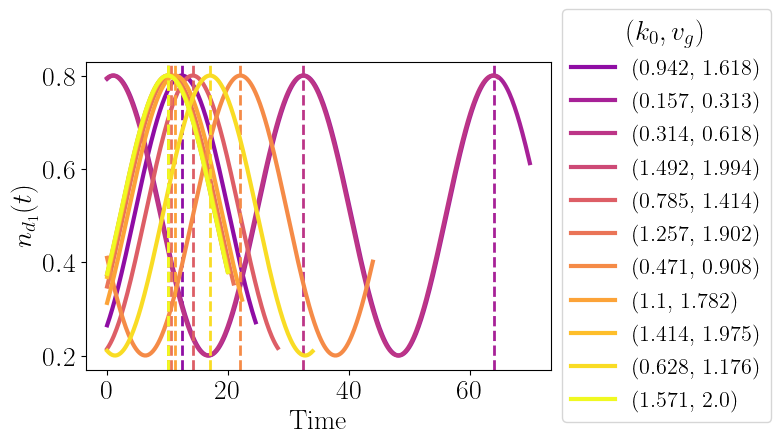

In [61]:
colors = plt.cm.plasma(np.linspace(0.3,1,len(file_list)))

fig, ax = plt.subplots(figsize=(6,4))

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name)  
  
    # calculate the time it takes it to hit the bond (scattering approx)
    vg = 2*np.sin(param_dict["K0"])
    tau_to_bond = param_dict["bond_index"]/vg
    
    lab = "("+str(round(param_dict["K0"],3)) + ", " + str(round(vg,3))+")" 
    
    plt.plot(times, d0_density, linewidth=3, label=lab , c=colors[i])
    
    plt.axvline(tau_to_bond, linestyle="dashed",c=colors[i], linewidth=2)
    
plt.legend(title=r"$(k_0, v_g)$",loc='center left', bbox_to_anchor=(1, 0.5))

plt.ylabel(r"$n_{d_1}(t)$")
plt.xlabel(r"Time")



# Generating Analysis dataframe

Here we put all the processed and raw data in a dataframe for convenient reading abd analysis

In [68]:
def rotate_rho(ρ, τ, T , ϕ0):
    # this rotates a qubits reduced density matrix around the x-axis up to angle tau*T
    # This is the free qubit rabi oscillations
    # Build the R matrix
    Rmatrix = np.zeros((2,2)) + 0j
    Rmatrix[0,0] = Rmatrix[1,1] = np.cos(τ*T)
    Rmatrix[1,0] = Rmatrix[0,1] =  -1j*np.exp(1j*ϕ0)*np.sin(τ*T)
    res_ = np.matmul(np.conj(Rmatrix.T), np.matmul(ρ, Rmatrix))
    # apply the rotation and return
    return res_

def get_bloch_angles(ρ):
    Cos_θ = 2*ρ[0,0] - 1
    θ_ = np.arccos(Cos_θ)
    Sin_ϕ = (ρ[1,0] - ρ[0,1])/(1j*np.sin(θ_))
    return Cos_θ,Sin_ϕ

def get_bloch_angles_time(ρ_list):
    # Calculate the Bloch angles for each time step

    theta_list = []
    phi_list = []
    for i in range(0,len(ρ_list)):
        # mixed state bloch sphere representation. Check page 34 of my notes for this 
        r = ρ_list[i]
        Cos_theta_p, Sin_phi_p = get_bloch_angles(r)
        
        theta_list.append(Cos_theta_p)
        phi_list.append(Sin_phi_p)
        
    return theta_list, phi_list

In [69]:
data_route = "../../data/exact_diag_new/L=21/"

file_list = get_file_names_on([], data_route)
file_list

['exact_L21_J1.0_t2.0_om0.5_Del2.0_xo0_k1.2566_bindex7_maxtau20.000_tstep0.040_alpha0.225_beta0.775_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t0.05_om0.3_Del2.0_xo0_k1.4923_bindex7_maxtau20.000_tstep0.040_alpha0.970_beta0.030_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t0.1_om0.0_Del2.0_xo0_k1.4923_bindex7_maxtau20.000_tstep0.040_alpha0.882_beta0.118_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t0.03_om0.7_Del2.0_xo0_k1.0996_bindex7_maxtau20.000_tstep0.040_alpha0.986_beta0.014_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t0.4_om0.0_Del2.0_xo0_k0.9425_bindex7_maxtau20.000_tstep0.040_alpha0.025_beta0.975_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t1.0_om0.0_Del2.0_xo0_k1.4137_bindex7_maxtau20.000_tstep0.040_alpha0.847_beta0.153_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t0.6_om0.0_Del2.0_xo0_k1.0996_bindex7_maxtau20.000_tstep0.040_alpha0.501_beta0.499_phi0.0_alpha_bond1.000.h5',
 'exact_L21_J1.0_t1.0_om0.0_Del2.0_xo0_k1.2566_bindex7_maxtau20.000_tstep0.040_alpha0.737_beta0.263_ph

In [70]:
# read the parameter dictionary to initialize 
param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_list[0])  

data_dict =  {key: [] for key in param_dict}
data_dict["times"] = []
data_dict["occupations"] = []
data_dict["d0_density"] = []
data_dict["qubit_rho"] = []
data_dict["entropy"] = []
data_dict["time_at_bond"] = []
data_dict["Max_entropy"] = []
data_dict["cos_theta"] = []
data_dict["sin_phi"] = []

for i in range(0,len(file_list)):
    file_name = file_list[i]
    param_dict, times, occupations, d0_density, qubit_rho, entropy = load_exact_diag(data_route, file_name) 
    # initialize the meta data
    for key in param_dict.keys():
        data_dict[key].append(param_dict[key])

    #  estimate the time that wavepacket spends at bondf
    bond_density = occupations[param_dict["bond_index"], :] + occupations[param_dict["bond_index"]+1, :]
    tau_bond = get_time_at_bond(times, bond_density)
    
    # get the bloch angles fo the qubit
    theta_list, phi_list = get_bloch_angles_time(qubit_rho)

    # save raw data 
    data_dict["times"].append(times.astype(np.float32))
    data_dict["occupations"].append(occupations.astype(np.float32))
    data_dict["d0_density"].append(d0_density.astype(np.float32)) 
    data_dict["qubit_rho"].append(qubit_rho.astype(np.complex64))
    # normalize entropy by maximally entangled singled 
    data_dict["entropy"].append((entropy/np.log(2)).astype(np.float32)) 
    # save processed data
    data_dict["time_at_bond"].append(tau_bond)
    data_dict["Max_entropy"].append(max(entropy/np.log(2)))
    data_dict["cos_theta"].append(theta_list)
    data_dict["sin_phi"].append(phi_list)

data_df = pd.DataFrame.from_dict(data_dict)

In [71]:
param_dict

{'L_qpc': 21,
 'Omega': 0.0,
 't': 1.5,
 'J': 1.0,
 'Jp': 1.0,
 'bond_index': 7,
 'K0': 0.7853981633974483,
 'X0': 0,
 'Spread': 2.0,
 'maxt_time': 20.0,
 'del_tau': 0.04008016032064128,
 'qubit_init': 'momentum',
 'Re_qubit_0': 0.416289371362026,
 'Im_qubit_0': 0.0,
 'Re_qubit_1': 0.0,
 'Im_qubit_1': -0.9092321811787181,
 'phi': 0.0,
 'alfabond': 1.0}

# Phase diagram

In [76]:
Om_ = 0.3

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["K0"]>0.0) & (data_df["t"]<3) & (data_df["alfabond"]==1.0)

data_S = data_df[cond_].sort_values(by="K0")

S_df = data_S.pivot_table(index='K0', columns='t', values='Max_entropy', 
                          aggfunc='mean')

S_df


t,0.01,0.03,0.05,0.07,0.09,0.10,0.20,0.30,0.40,0.60,0.80,1.00,1.50,2.00
K0,,,,,,,,,,,,,,
0.628319,0.008218,0.051202,0.105624,0.152275,0.180788,0.187685,0.202130,0.203098,0.161040,0.133435,0.081833,0.092158,0.053405,0.010757
0.785398,0.005236,0.033688,0.072109,0.108694,0.135752,0.144586,0.153861,0.155985,0.151590,0.129732,0.102755,0.079895,0.046912,0.012910
0.942478,0.002246,0.015240,0.034780,0.056823,0.078261,0.088046,0.134338,0.136482,0.133555,0.117748,0.106179,0.086072,0.043033,0.011623
1.099557,0.001595,0.011030,0.025731,0.043154,0.061199,0.069906,0.119810,0.127917,0.130675,0.127077,0.116302,0.092229,0.036509,0.011956
1.256637,0.001332,0.009263,0.021705,0.036561,0.052101,0.059677,0.107629,0.122022,0.130843,0.138127,0.127749,0.100433,0.035883,0.013198
1.413717,0.001089,0.007634,0.018028,0.030642,0.044125,0.050836,0.098692,0.118088,0.131420,0.145639,0.135761,0.105919,0.037109,0.014155
1.492257,0.001028,0.007219,0.017087,0.029119,0.042062,0.048540,0.096252,0.117024,0.131593,0.147607,0.137760,0.107248,0.037398,0.014371
1.570796,0.001002,0.007047,0.016698,0.028495,0.041225,0.047616,0.095381,0.116662,0.131653,0.148268,0.138429,0.107714,0.037519,0.014441


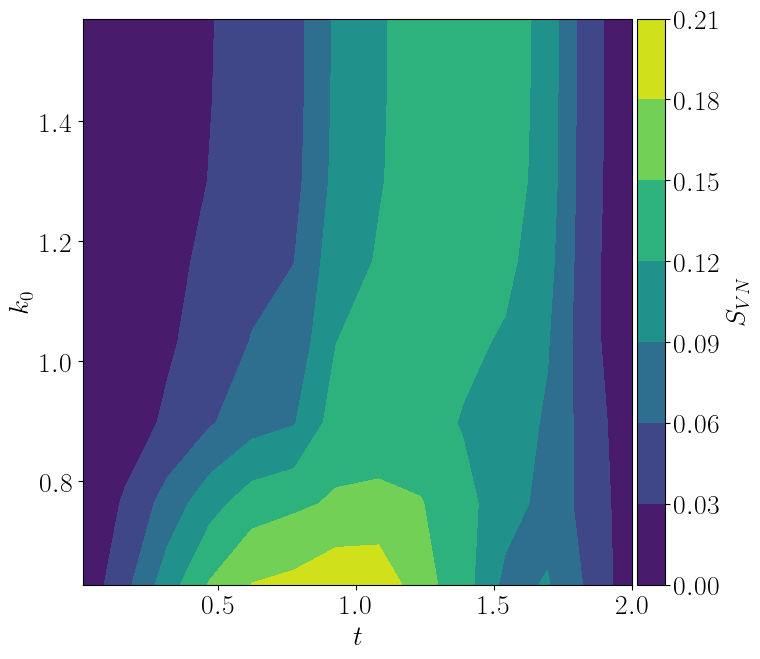

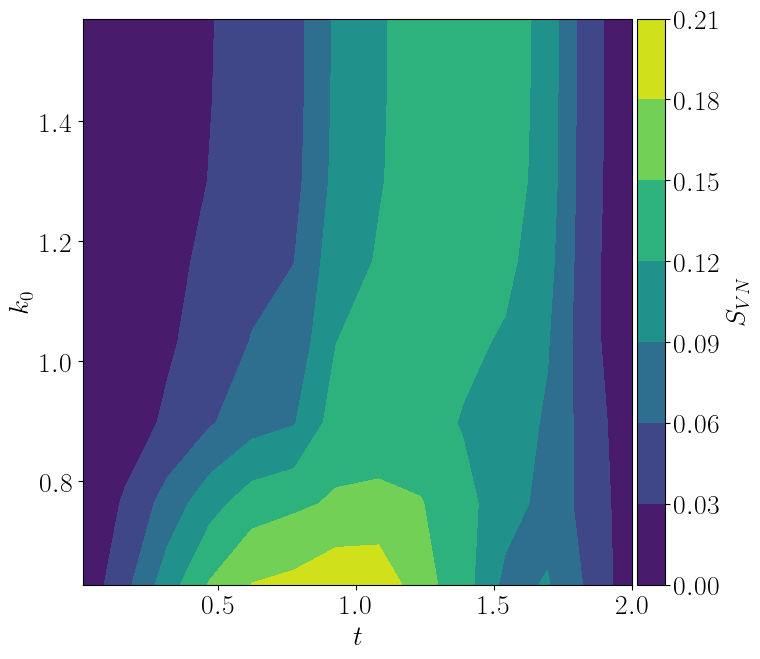

In [78]:
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values,extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)])

ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}$', rotation=90)

plt.tight_layout()
fig, ax = plt.subplots(1,1,figsize=(bwidth+1,bwidth))

vg_array = S_df.index
t_array = S_df.columns
im = ax.contourf(S_df.values,extent=[min(t_array), max(t_array),min(vg_array), max(vg_array)])

ax.set_ylabel(r"$k_0$")
ax.set_xlabel(r"$t$")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax, shrink=0.9)   
cbar.ax.set_ylabel(r'$S_{VN}$', rotation=90)

plt.tight_layout()

# Entropy Production

In [79]:
t_ = 0.1

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_)

curr_df = data_df[cond_].sort_values(by="K0")


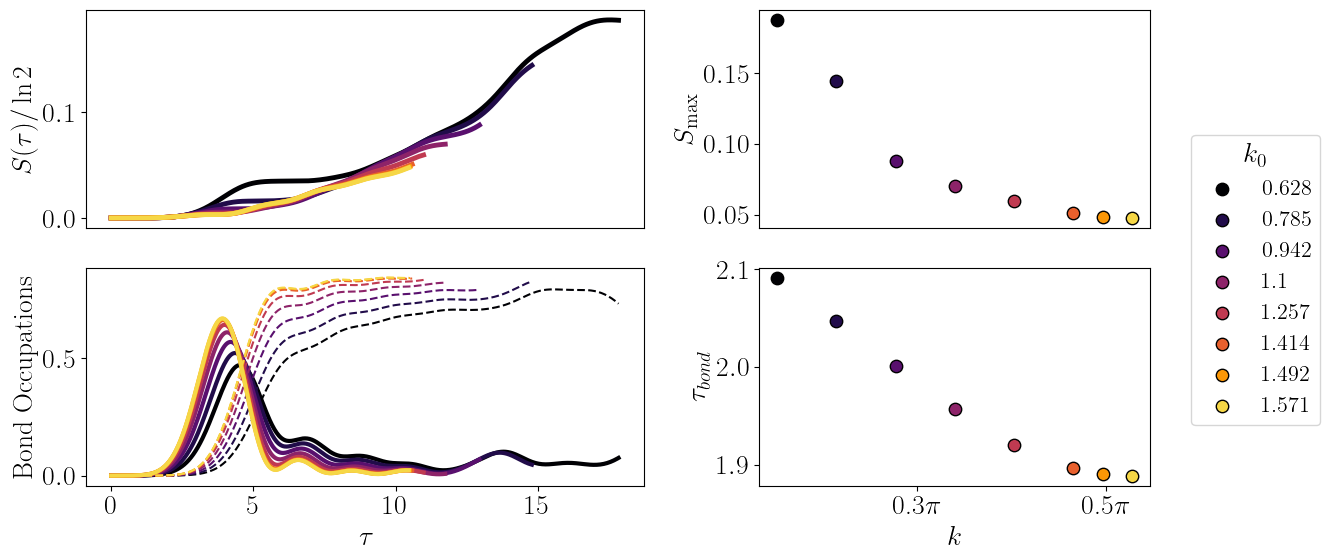

In [80]:
# Create 2x2 sub plots

fig = plt.figure(figsize=(12,6))

#plt.suptitle(om_s + ", " + bw_s + ", " + t_s )
gs = gridspec.GridSpec(2, 2, width_ratios=[1,0.7])
K0_unique = curr_df["K0"].unique()
colors = plt.cm.inferno(np.linspace(0.0,0.9,len(K0_unique)))

for i in range(0,len(K0_unique)):
    # generate the legend
    lab = str(round(K0_unique[i],3))
    # Entropy in time
    ax = plt.subplot(gs[0, 0]) # make it span both columns
    xvals = curr_df[curr_df["K0"]== K0_unique[i]]["times"].item()
    yvals = curr_df[curr_df["K0"]== K0_unique[i]]["entropy"].item()
    ax.plot(xvals,yvals, linewidth=3.5, c=colors[i])
    
    # max entropy
    ax = plt.subplot(gs[0, 1])
    ax.scatter(K0_unique[i], max(yvals), c=[colors[i]], s=80, edgecolor='black', zorder=7,label=lab)
    
    # plot density at the bond in time and transmission
    bindex = curr_df[curr_df["K0"]== K0_unique[i]]["bond_index"].item()
    occ_matrix = curr_df[curr_df["K0"]== K0_unique[i]]["occupations"].item()
    bond_density = occ_matrix[bindex, :] + occ_matrix[bindex+1, :] 
    transmission = np.sum(occ_matrix[bindex+2:,:], axis=0)
    
    ax = plt.subplot(gs[1, 0]) # row 1, col 0
    ax.plot(xvals,bond_density, linewidth=3, c=colors[i])    
    ax.plot(xvals, transmission, linestyle="dashed", linewidth=1.5, c=colors[i])
    # plot time spent at bond
    ax = plt.subplot(gs[1, 1]) # row 1, col 1
    ax.scatter(K0_unique[i], curr_df[curr_df["K0"]== K0_unique[i]]["time_at_bond"], c=[colors[i]], s=80, edgecolor='black', zorder=7)





# Set up labels and legends

plt.subplot(gs[0, 0]).set_ylabel(r"$S(\tau)/\ln{2}$")
plt.subplot(gs[0, 0]).set_xticks([])

plt.subplot(gs[0, 1]).set_xticks([])
plt.subplot(gs[0, 1]).set_ylabel(r"$S_{\rm{max}}$")
# plt.subplot(gs[0, 1]).legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.legend(title=r"$k_0$", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(gs[1, 0]).set_ylabel(r"Bond Occupations")
plt.subplot(gs[1, 0]).set_xlabel(r"$\tau$")

plt.subplot(gs[1, 1]).set_ylabel(r"$\tau_{bond}$")
plt.subplot(gs[1, 1]).set_xlabel(r"$k$")
# write x axis in units of pi
plt.subplot(gs[1, 1]).xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

plt.subplots_adjust(wspace=0.16, hspace=0.09)

plt.tight_layout()

# Single cases

In [81]:
k0_list = np.sort(data_df["K0"].unique())
print(k0_list)
k0_ = k0_list[-3]

# filter out for the parameters we want 
cond_ = (data_df["Omega"]==Om_) & (data_df["t"]==t_) & (data_df["K0"]==k0_)
curr_df = data_df[cond_]


[0.62831853 0.78539816 0.9424778  1.09955743 1.25663706 1.41371669
 1.49225651 1.57079633]


## Wavefunction

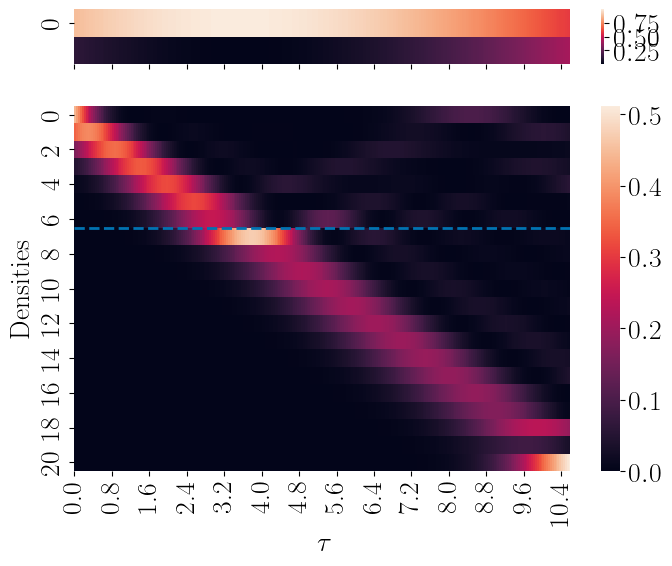

In [82]:
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True ,gridspec_kw={'height_ratios': [0.15, 1]})

# n_d1
n_d1 = curr_df["d0_density"].item()
sns.heatmap([n_d1,1-n_d1],ax=ax[0])
traj_matrix = curr_df["occupations"].item()
time_range = curr_df["times"].item()
sns.heatmap(traj_matrix,ax=ax[1])

ax[1].set_xlabel(r"$\tau$")

ax[1].set_ylabel("Densities")

# time ticks
delta_tau = time_range[1] - time_range[0]
tick_posx = np.arange(0,len(time_range),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)

ax[1].axhline(curr_df["bond_index"].item(), linewidth=2, linestyle="dashed")
ax[1].set_xticks(tick_posx,xtick_label);


## Bloch Sphere

In [83]:
costheta = curr_df["cos_theta"].item()
sinphi = curr_df["sin_phi"].item()
time_range = curr_df["times"].item()
bindex = curr_df["bond_index"].item()
ϕ0 = curr_df["phi"].item()
rhot = curr_df["qubit_rho"].item()

τbond = bindex/(2*J*np.sin(k0_))
cosθ0 = costheta[0]

data_df.columns


Index(['L_qpc', 'Omega', 't', 'J', 'Jp', 'bond_index', 'K0', 'X0', 'Spread',
       'maxt_time', 'del_tau', 'qubit_init', 'Re_qubit_0', 'Im_qubit_0',
       'Re_qubit_1', 'Im_qubit_1', 'phi', 'alfabond', 'times', 'occupations',
       'd0_density', 'qubit_rho', 'entropy', 'time_at_bond', 'Max_entropy',
       'cos_theta', 'sin_phi'],
      dtype='object')

In [84]:
rho_free_list = [rhot[0]]
theta_free_list = [np.arccos(np.real(cosθ0))]
phi_free_list = [ϕ0]

# calculate the free qubit bloch angles as a funciton of time
# by using the rotaiton matrix of the free dynamics

for i in range(1,len(time_range)):
    # rotate up to time tau
    τ = time_range[i] 
    rho_tau = rotate_rho(rho_free_list[0], τ, t_ , ϕ0)
    # get the angles at that tau
    Cos_theta_p, Sin_phi_p = get_bloch_angles(rho_tau)
    
    rho_free_list.append(rho_tau)
    theta_free_list.append(np.arccos(Cos_theta_p))
    phi_free_list.append(np.arcsin(Sin_phi_p))


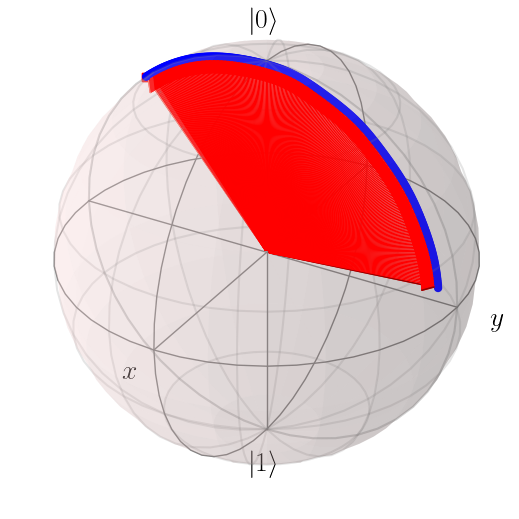

In [85]:
# Now plot the numerical coupled case
dd_theta = np.arccos(costheta)
dd_phi = np.arcsin(sinphi)

x_ = np.sin(dd_theta)*np.cos(dd_phi)
y_ = np.sin(dd_theta)*np.sin(dd_phi)
z_ = np.asarray(costheta)

coupled_vectors = [[i,j,k] for i,j,k in zip(x_.real,y_.real,z_.real)]
# make all vectors the same color

# writting out free case solution in spherical coordinates
x_free = np.sin(theta_free_list)*np.cos(phi_free_list)
y_free = np.sin(theta_free_list)*np.sin(phi_free_list)
z_free = np.cos(theta_free_list)

free_points = [x_, y_, z_]
free_first= [x_[0], y_[0], z_[0]] # first point for different color

bs = Bloch()

bs.add_vectors(coupled_vectors)
# now plot the first and last vectors and points in a different color
bs.add_vectors(coupled_vectors[0])
bs.add_vectors(coupled_vectors[-1])
bs.vector_color = ["red"]*len(coupled_vectors) + ["salmon", "darkred"]
bs.vector_width = 1.0

# now add the free vectors
bs.add_points(free_points)
bs.add_points(free_first)

#bs.view = [-20, 30]  

bs.show()

Text(0.5, 0, '$\\tau$')

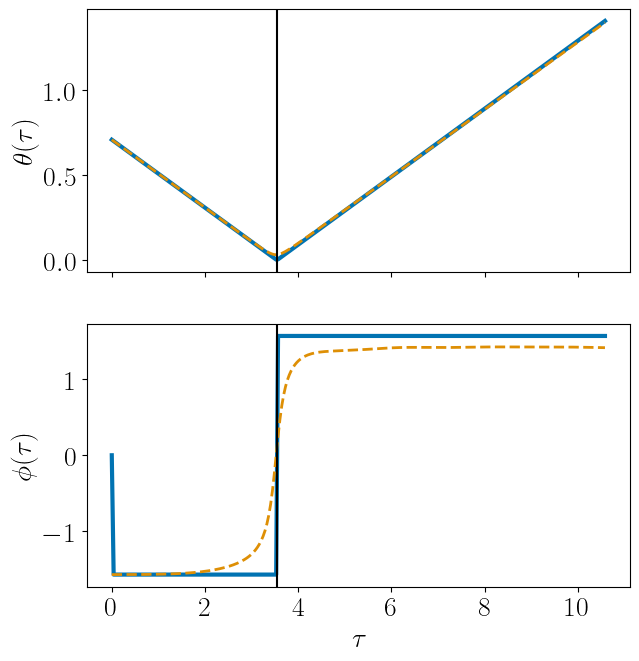

In [86]:

fig, ax = plt.subplots(2,1,figsize=(bwidth,1.5*bheight), sharex = True)

ax[0].plot(time_range, np.real(theta_free_list), linewidth=3)
ax[0].plot(time_range, np.real(dd_theta), linewidth=2.0, linestyle="dashed")
ax[0].axvline(τbond, c="black")

ax[1].plot(time_range, np.real(phi_free_list), linewidth=3 )
ax[1].plot(time_range, np.real(dd_phi),linewidth=2.0, linestyle="dashed")
ax[1].axvline(τbond,c="black")

ax[0].set_ylabel(r"$\theta (\tau)$")
ax[1].set_ylabel(r"$\phi (\tau)$")
ax[1].set_xlabel(r"$\tau$")